# Hands-on Session on Quantum Computing with Qiskit

<img src="logo-with_background.svg" alt="Qiskit Logo" width="300"/>

## Workshop contents
- Quantum Computing basics - bits and qubits
- Introduction to single qubit Quantum Gates and Circuits
- Run a simple circuit
- Qiskit Runtime Primitives
- Two qubit gate and entanglement
- Running a Bell State circuit


Let's start with importing classes and libraries.

In [2]:
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler, BackendSampler
from qiskit.circuit.library import *
from qiskit.circuit.random import random_circuit
from qiskit.visualization import plot_histogram, array_to_latex, plot_bloch_multivector
from qiskit.quantum_info import Statevector

from qiskit_ibm_runtime import Sampler, QiskitRuntimeService, Options, Session
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

import numpy as np

## Let's start with bits - 0 & 1

### bitstring = 0
Dirac notation = $|0\rangle$  
matrix = $ \begin{bmatrix} 1 \\ 0 \end{bmatrix} \, \, \, \, $

### bitstring = 1
Dirac notation = $ |1\rangle $  
matrix = $\begin{bmatrix} 0 \\ 1 \end{bmatrix}$

## Quantum bits have richer state space

**Classical:** Bits $0$ or $1$

**Quantum:** Qubits $|\phi\rangle = \alpha |0\rangle + \beta |1\rangle$
 such that $|\alpha|^2 + |\beta|^2=1$ for $\alpha, \beta \in \mathbb{C}$.

The fact that a qubit can exist between $|0\rangle$ and $|1\rangle$ is called *superposition*.
<img src="BlochSphere.png" alt="Bloch Sphere" width="300"/>

## Gates
Gates are operations that act on qubits. The most commonly used gates are unitary such that $U^{\dagger}U = I$ and therefore reversible.


3 ways to represent quantum gates:
- circuit description
- Dirac notation
- matrices

Gates that act on one qubit are called single qubit gates.

Gates that act on *n*-qubits are called *n*-qubit gates.

## X Gate

- equivalent to a classical NOT gate (i.e. a bit flip) <img src="classical-not.jpg" alt="Classical Not" width="100"/>
- flips the state of the input qubit from $|0\rangle \rightarrow |1\rangle$ and $|1\rangle \rightarrow |0\rangle$


In [3]:
print('X (1q gate)')
xgate = XGate()
array_to_latex(xgate.to_matrix())

X (1q gate)


<IPython.core.display.Latex object>

**for an X gate applied to a qubit in state 0**

Dirac notation = $X|0\rangle$ = $|1\rangle$

matrix = $ \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} 1 \\ 0 \end{bmatrix} = \begin{bmatrix} 0*1 + 1*0 \\ 1*1 + 0*0 \end{bmatrix} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

**for an X gate applied to a qubit in state 1**

Dirac notation = $X|1\rangle$ = $|0\rangle$

matrix = $ \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} 0 \\ 1 \end{bmatrix} = \begin{bmatrix} 0*0 + 1*1 \\ 1*0 + 0*1 \end{bmatrix} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$


Applying a gate to a pure quantum state = matrix multiplication

## X Gate as a circuit

- each qubit is a line (wire)
- gates run from left to right in parallel

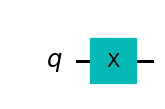

In [4]:
qc_x = QuantumCircuit(1)
qc_x.x(0)
qc_x.draw('mpl', scale=1.5)

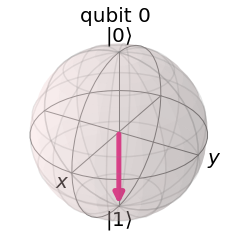

In [5]:
state = Statevector(qc_x)
plot_bloch_multivector(state)

## Measurement
* Our circuit is incomplete, we changed the quantum state but we have not measured it
* Measurement takes the qubit from the quantum domain and collapses it to the classical domain
* When we measure the result will always be a $|0\rangle$ or a $|1\rangle$

We need to rebuild our circuit with a classical register and add operations that measure the qubit state

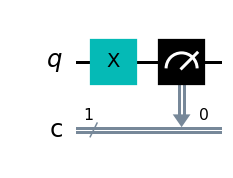

In [6]:
qc_x = QuantumCircuit(1,1)
qc_x.x(0)
qc_x.measure([0],[0])
qc_x.draw('mpl', scale=1.5)

## Running the circuit
* We will run on a simulator
* The simulator mimics a real quantum device, including noise
* Typically run the circuit many times, sampling the output

In [7]:
# load the service and set the backend to the simulator
service = QiskitRuntimeService(channel="ibm_quantum")
backend = "ibmq_qasm_simulator"

# Make a noise model
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}

# Set number of shots, optimization_level and resilience_level
options.execution.shots = 1000
options.optimization_level = 0
options.resilience_level = 0

with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(qc_x)


## The result

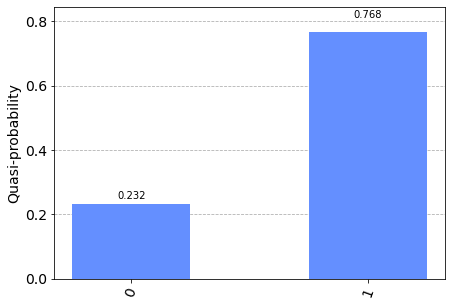

In [8]:
result_prob = job.result().quasi_dists[0].binary_probabilities()
plot_histogram(result_prob)

* Not what we would expect.
* This is the result of noise which we will explore later
* First we need to better understand how to run circuits

## What is Qiskit runtime?

Qiskit Runtime is a *quantum computing service* and *programming model* that allows users to optimize workloads and efficiently execute them on quantum systems at scale. The programming model extends the existing interface in Qiskit with a set of new primitive programs.
<img src="qiskit_runtime.png" alt="QiskitRuntime"/>

## Why use Qiskit Runtime?


- **Efficiency** : Highly optimized routines and options for iterative workloads designed for quantum backends
- **Latency** : Scheduling, job prioritizing and shared caching using the Sessions framework for lower latency and faster turn result times.
- **Consistency** : Consistent programming model to build upon complex routines across the service with newer additions to complement the existing primitive model
- **Customizablity** : Management of iterative routines with customized circuits based on its context and paramaters of the job
- **Error Mitigation and Suppression** : Error mitigation and suppression research advancements through simple abstracted interfaces for increased quality of information.

To maximize a given _Quantum workflow_, which is predominantly a QPU on cloud + classical computation, we now have a computing programming model that conforms to a service which is built to optimize workloads with efficient execution at scale.

## Qiskit Runtime Primitives: Introducing Sampler and Estimator


* The core capability of quantum computers that sets them apart from classical computers is their ability to generate non-classical probability distributions at their outputs. 

* The inherent nature of probabilistic results requires us to have multiple runs for the same circuit to generate usable information in the form of probability distributions.

* The native operations that we can do with probability distributions are to sample from it or to estimate quantities from it. 

From these we have our two primitives named **Sampler** and **Estimator**

### The Sampler

* takes a user circuits as an input
* samples from its output, estimating the entire quasi-probability distribution of a given quantum circuit. 
* provides users a way to better evaluate shot results using error mitigation

What does quasi-probability mean?

- Can be negative values
- Quantum mechanics allows for events with a negative expectation values, to acount for phenomena like destructive interference.

[Reference](https://en.wikipedia.org/wiki/Quasiprobability_distribution)

### The Estimator

While the Sampler gives the complete distribution over the entire output, there may be times where you may be interested in information about particular outcomes.

* calculates and interprets expectation values of operators of interest. 
* takes circuits and observables as inputs and allows users to selectively group between circuits and observables for execution to efficiently evaluate expectation values and variances for a given parameter input.
* allows users to efficiently calculate and interpret expectation values of quantum operators required for many algorithms.



## Hadamard Gate

- no classical equivalent
- puts a qubit into superposition $|0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ and $|1\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

In [9]:
print('H (1q gate)')
hgate = HGate()
array_to_latex(hgate.to_matrix())

H (1q gate)


<IPython.core.display.Latex object>

**for an H gate applied to a qubit in state 0**

Dirac notation = $H|0\rangle$ = $|+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$

matrix = $ \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} \begin{bmatrix} 1 \\ 0 \end{bmatrix}$


**for an H gate applied to a qubit in state 1**

Dirac notation = $H|1\rangle$ = $|-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$

matrix = $ \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

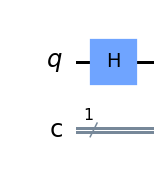

In [10]:
qc_h = QuantumCircuit(1,1)
qc_h.h(0)
qc_h.draw('mpl', scale=1.5)

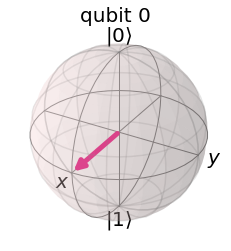

In [11]:
state = Statevector(qc_h)
plot_bloch_multivector(state)

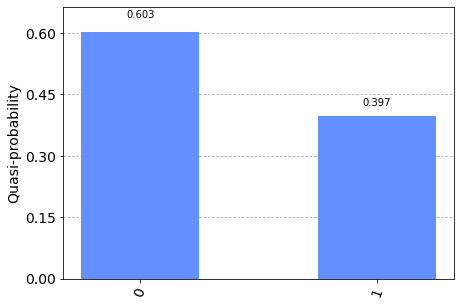

In [12]:
qc_h.measure([0],[0])

with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(qc_h)

result_prob = job.result().quasi_dists[0].binary_probabilities()
plot_histogram(result_prob)

## Error mitigation

- There are techniques that allow some of the quantum errors to be mitigated
- Some are simple (low cost) others can be quite complex (exponential cost)
- Primitives have a very simple knob to allow choosing different mitigation levels

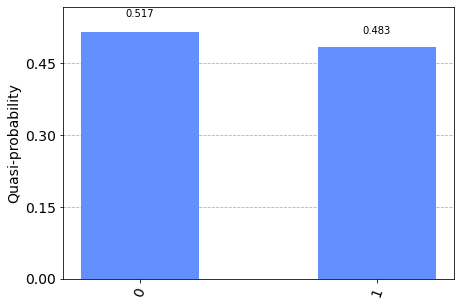

In [13]:
options.resilience_level = 1  # add in M3 measurement mitigation

with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(qc_h)

result_prob = job.result().quasi_dists[0].binary_probabilities()
plot_histogram(result_prob)

## A 2 qubit gate: Controlled-Not Gate
This gate can be referred to as CNOT or CX. This 2-qubit gate applies a bit flip on one qubit depending on the state of another qubit.


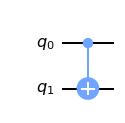

In [14]:
qc_cx = QuantumCircuit(2)
qc_cx.cx(0,1)
qc_cx.draw('mpl')

If q0 = 1, q1 flips  
if q0 = 0, q1 doesn't flip


so if q0 = 1, then if q1 was 0 it will become 1, if q1 was 1 it will become 0    
and if q0 = 0, then q1 is unchanged

Dirac notation:
$CNOT|00\rangle = |00\rangle$
$CNOT|10\rangle = |11\rangle$

## Matrix representation
* Because it applies to two qubits, the matrix is 4 x 4.  
* It creates a state that increases the state space by a factor of 2
* This is an entanging operation, as we entangle more qubits the state space grows exponentially


In [15]:
print('CX (2q gate)')
cxgate = CXGate()
array_to_latex(cxgate.to_matrix())

CX (2q gate)


<IPython.core.display.Latex object>

## Basic 2 qubit circuit

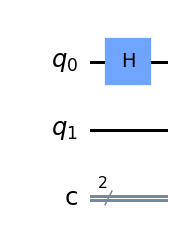

In [16]:
qc2 = QuantumCircuit(2, 2)
qc2.h(0)
qc2.draw('mpl', scale=1.5)

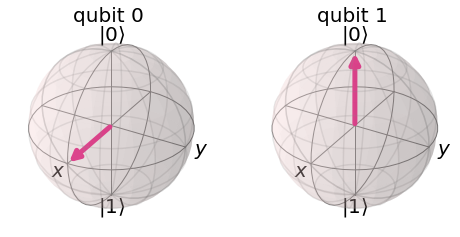

In [17]:
state = Statevector(qc2)
plot_bloch_multivector(state)

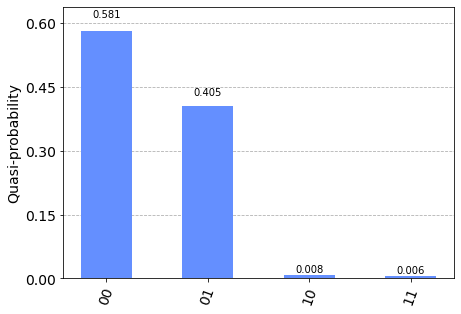

In [18]:
qc2.measure([0,1],[0,1])

options.resilience_level = 0  # no error mitigation

with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(qc2)

result_prob = job.result().quasi_dists[0].binary_probabilities()
plot_histogram(result_prob)

* Expected that we should have equal 00 and 01 states and no 10 or 11 states.  
* Noise is a problem again

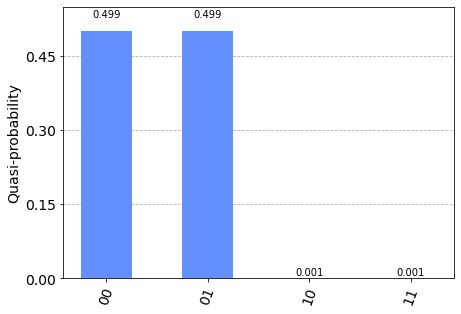

In [19]:
options.resilience_level = 1  # add in M3 measurement mitigation

with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(qc2)

result_prob = job.result().quasi_dists[0].binary_probabilities()
plot_histogram(result_prob)

With error mitigation results are much closer to ideal

## The Bell State

- Simplest implementation of entanglement
- Apply a Hadamard on q0 followed by a CNOT: control = q0, target = q1

$$ |\phi_{\text{Bell}}\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) $$

## Circuit Construction

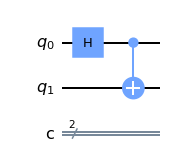

In [20]:
qc_bell = QuantumCircuit(2, 2)
qc_bell.h(0)
qc_bell.cx(0,1)
qc_bell.draw('mpl')

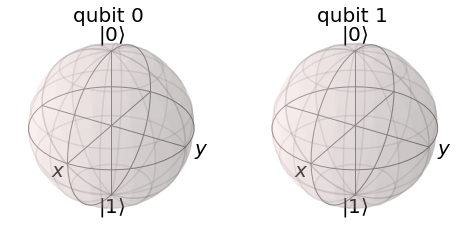

In [21]:
state = Statevector(qc_bell)
plot_bloch_multivector(state)

Whoops!  We can't visualize this state!

## Let's check the measurement statistics

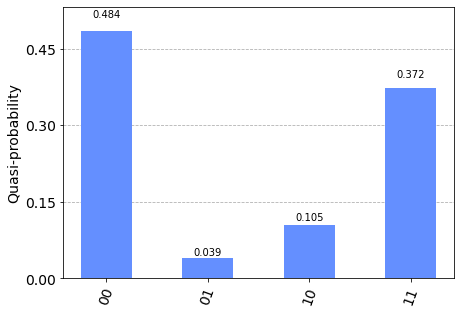

In [22]:
qc_bell.measure([0,1],[0,1]) # add the measurement
options.resilience_level = 0  # no mitigation

with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(qc_bell)

result_prob = job.result().quasi_dists[0].binary_probabilities()
plot_histogram(result_prob)

## Use error mitigation to improve the result

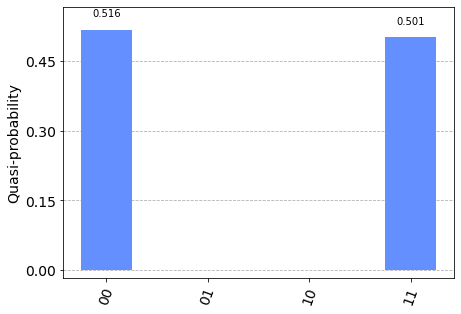

In [23]:
options.resilience_level = 1  # add in M3 measurement mitigation

with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(qc_bell)

result_prob = job.result().quasi_dists[0].binary_probabilities()
plot_histogram(result_prob)

In [24]:
print(result_prob)

{'00': 0.5161061484918903, '01': -0.0010785979826232544, '10': -0.01627520067266334, '11': 0.5012476501633963}


## Run your Bell State on real hardware

In [28]:
least_busy_device = service.least_busy(filters=lambda b: (b.configuration().simulator==False) & (b.name!='ibmq_dublin'))
least_busy_device

<IBMBackend('ibm_wellington')>

In [70]:
hw_result = None
with Session(service, backend=least_busy_device) as session:
    
    options = Options(resilience_level=0)
    sampler0 = Sampler(options=options)
    options = Options(resilience_level=1)
    sampler1 = Sampler(options=options)
    job0 = sampler0.run(circuits=[qc_bell], shots=8000)
    job1 = sampler1.run(circuits=[qc_bell], shots=8000)
    
    # You can see that the results are quasi probabilities, not counts
    hw_results = [job0.result().quasi_dists[0].binary_probabilities(), 
                  job1.result().quasi_dists[0].binary_probabilities()]

## Results

In [71]:
print('Results resilience level 0 ', hw_results[0])
print('Results resilience level 1 ', hw_results[1])

Results resilience level 0  {'00': 0.482875, '01': 0.015875, '10': 0.025125, '11': 0.476125}
Results resilience level 1  {'00': 0.5052399839948363, '01': -0.0023564476882565874, '10': 0.0035989830427451265, '11': 0.49351748065067513}


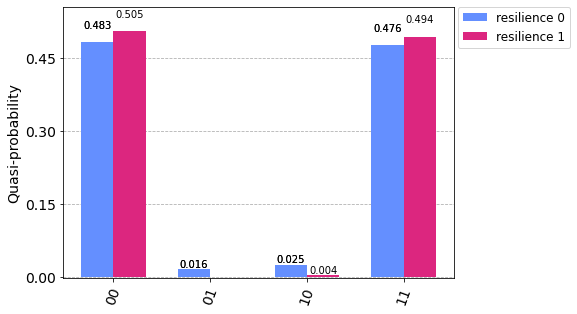

In [72]:
plot_histogram(hw_results, legend=['resilience 0', 'resilience 1'])

## To learn more

* Qiskit textbook  https://qiskit.org/learn/
* Qiskit tutorials https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
* Additional notebooks in the Quantum Lab